In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())

In [3]:
def read_data(file_path):

    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

In [4]:
def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

In [5]:
def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

In [6]:
def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [7]:
# %%

# ------- THE PROGRAM TO LOAD DATA AND TRAIN THE MODEL -------

# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)

LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

# %%

keras version  2.2.4


In [8]:
print("\n--- Load, inspect and transform data ---\n")

# Load data set containing all the data from csv
df = read_data('/home/nsc/seers/dataset/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')


--- Load, inspect and transform data ---



In [9]:
# Describe the data
show_basic_dataframe_info(df, 20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203

First 20 rows of the dataframe:

    user-id activity       timestamp  x-axis  y-axis  z-axis
0        33  Jogging  49105962326000    -0.7    12.7     0.5
1        33  Jogging  49106062271000     5.0    11.3     1.0
2        33  Jogging  49106112167000     4.9    10.9    -0.1
3        33  Jogging  49106222305000    -0.6    18.5     3.0
4        33  Jogging  49106332290000    -1.2    12.1     7.2
5        33  Jogging  49106442306000     1.4    -2.5    -6.5
6        33  Jogging  49106542312000    -0.6    10.6     5.7
7        33  Jogging  49106652389000    -0.5    13.9     7.1
8        33  Jogging  49106762313000    -8.4    11.4     5.1
9        33  Jogging  49106872299000     1.0     1.4     1.6
10       33  Jogging  49106982315000    -8.2    19.6     2.7
11       33  Jogging  49107092330000     1.4     5.8     3.0
12       33  Jogging  49107202316000    -1.9    -3.0    -0.3
13       33  Jogging  49107312332

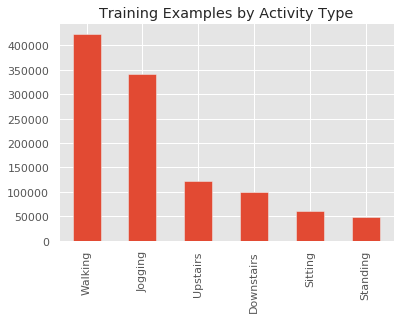

In [10]:
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

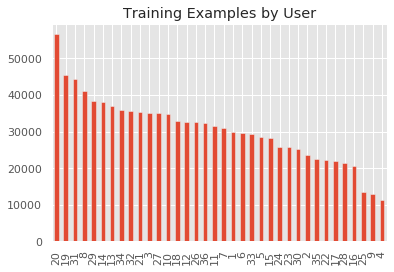

In [11]:
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

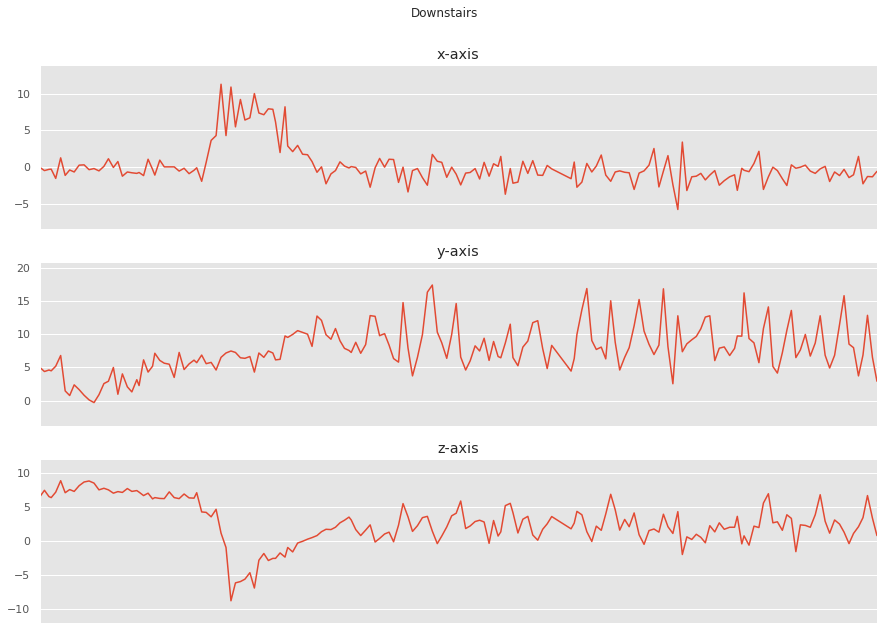

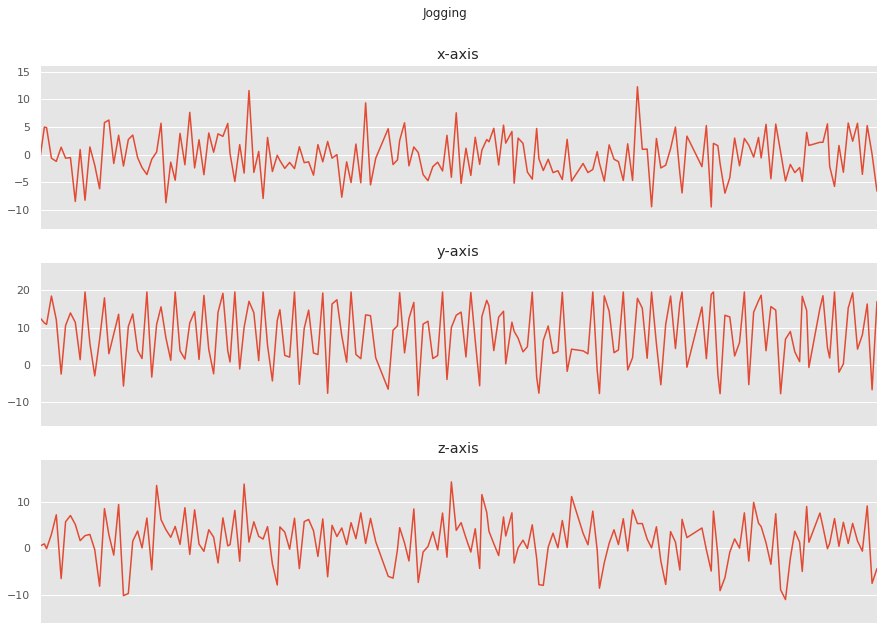

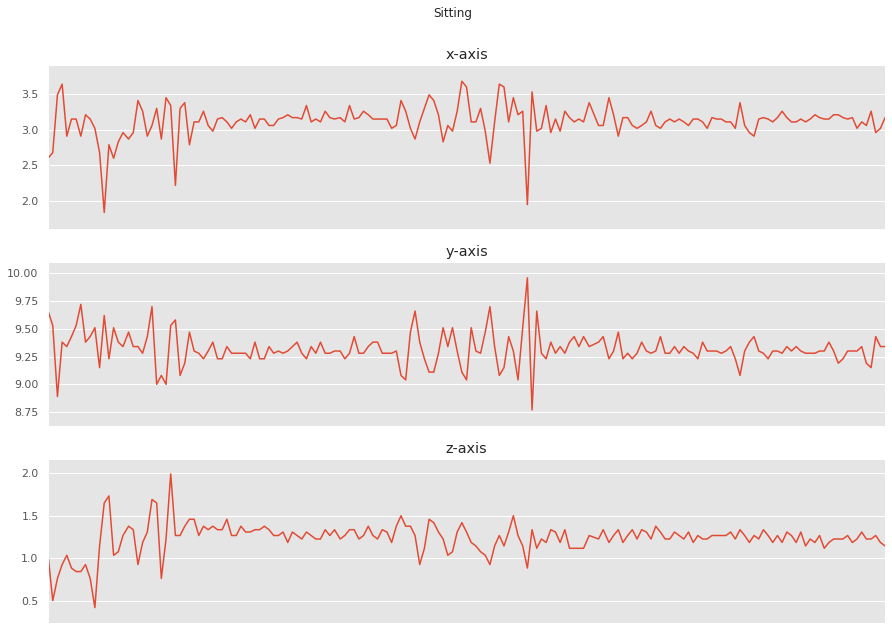

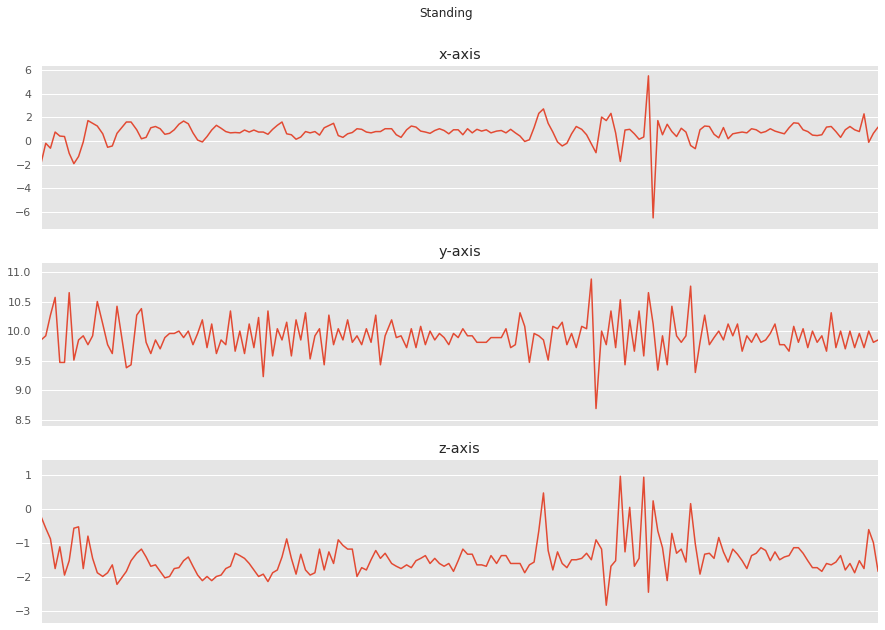

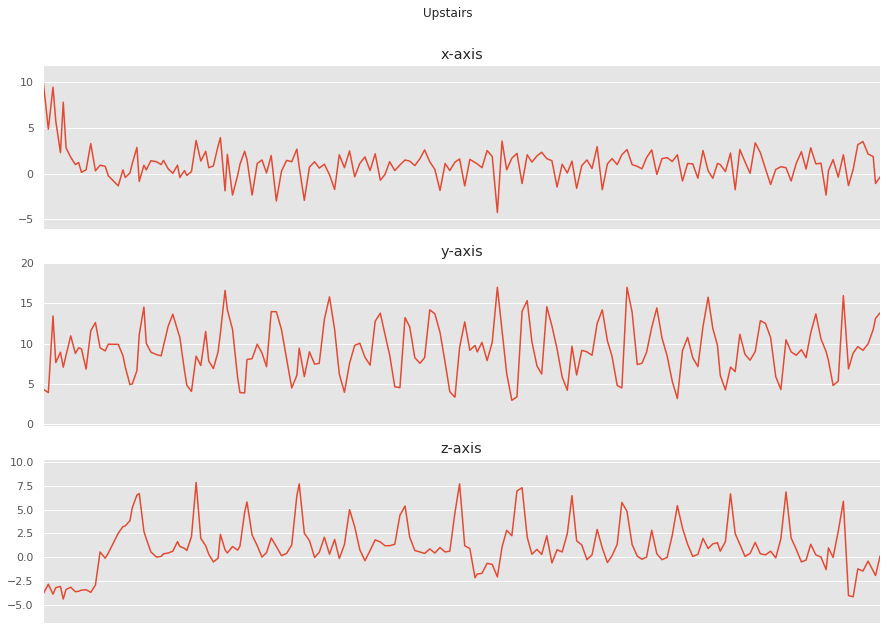

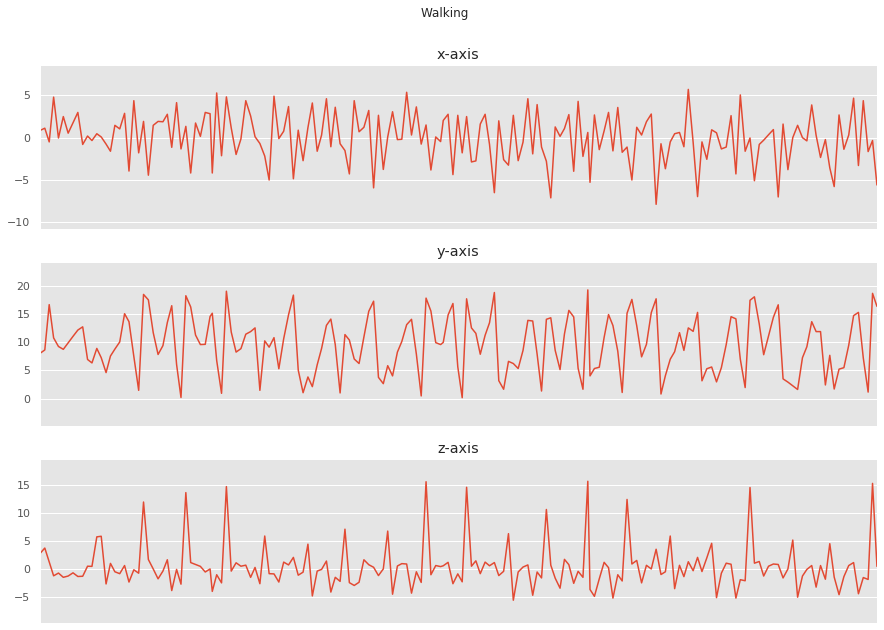

In [12]:
for activity in np.unique(df["activity"]):
    subset = df[df["activity"] == activity][:180]
    plot_activity(activity, subset)

In [13]:
# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [14]:
df

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1
5,33,Jogging,49106442306000,1.4,-2.5,-6.5,1
6,33,Jogging,49106542312000,-0.6,10.6,5.7,1
7,33,Jogging,49106652389000,-0.5,13.9,7.1,1
8,33,Jogging,49106762313000,-8.4,11.4,5.1,1
9,33,Jogging,49106872299000,1.0,1.4,1.6,1


In [ ]:
# %%

print("\n--- Reshape the data into segments ---\n")

# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

# Normalize features for training data set
df_train['x-axis'] = feature_normalize(df['x-axis'])
df_train['y-axis'] = feature_normalize(df['y-axis'])
df_train['z-axis'] = feature_normalize(df['z-axis'])
# Round in order to comply to NSNumber from iOS
df_train = df_train.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

# Reshape the training data into segments
# so that they can be processed by the network
x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

# %%

In [18]:
y_train

array([5, 5, 5, ..., 2, 2, 2])

In [19]:
x_train

array([[[-0.013259, -0.096782, -0.130589],
        [-0.074907, -0.074907, -0.007293],
        [-0.080873, -0.112691, -0.108714],
        ...,
        [-0.779786, -0.02057 , -0.504749],
        [-0.135169, -0.46464 , -0.593563],
        [-0.135169,  0.122678,  0.962112]],

       [[ 0.116003,  0.127935,  0.255208],
        [ 0.456062,  0.277084,  0.127935],
        [ 0.155776,  0.026514, -0.08485 ],
        ...,
        [-0.957414, -0.312797, -0.682377],
        [-0.223983,  0.025269, -0.931629],
        [-0.215388, -0.327122,  1.042331]],

       [[ 0.199526,  0.255208, -0.214112],
        [ 0.255208,  0.70862 ,  0.338732],
        [ 0.054355,  0.171685,  0.014582],
        ...,
        [-0.948819, -0.117979, -0.046355],
        [-0.158089, -0.46464 , -0.278417],
        [-0.135169,  0.446419,  1.388992]],

       ...,

       [[ 1.211427,  1.189527,  1.199747],
        [ 1.211427,  1.205587,  1.211427],
        [ 1.205587,  1.205587,  1.199747],
        ...,
        [ 0.397328,  0.397

In [20]:
print("\n--- Reshape data to be accepted by Keras ---\n")

# Inspect x data
print('x_train shape: ', x_train.shape)
# Displays (20869, 40, 3)
print(x_train.shape[0], 'training samples')
# Displays 20869 train samples

# Inspect y data
print('y_train shape: ', y_train.shape)
# Displays (20869,)

# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))


--- Reshape data to be accepted by Keras ---

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [23]:
num_time_periods

80

In [16]:
# Set input_shape / reshape for Keras
# Remark: acceleration data is concatenated in one array in order to feed
# it properly into coreml later, the preferred matrix of shape [40,3]
# cannot be read in with the current version of coreml (see also reshape
# layer as the first layer in the keras model)
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)

print('x_train shape:', x_train.shape)
# x_train shape: (20869, 120)
print('input_shape:', input_shape)
# input_shape: (120)

# Convert type for Keras otherwise Keras cannot process the data
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

x_train shape: (20868, 240)
input_shape: 240


In [25]:
# %%

# One-hot encoding of y_train labels (only execute once!)
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)
# (4173, 6)

# %%

New y_train shape:  (20868, 6)


In [26]:
y_train

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [29]:
TIME_PERIODS
num_sensors

3

In [18]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

W1014 21:46:48.203203 139670469752640 deprecation_wrapper.py:119] From /home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1014 21:46:48.216628 139670469752640 deprecation_wrapper.py:119] From /home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1014 21:46:48.224343 139670469752640 deprecation_wrapper.py:119] From /home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1014 21:46:48.256006 139670469752640 deprecation_wrapper.py:119] From /home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is depre


--- Create neural network model ---

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 160)           160160    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 160)            256160    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16

In [19]:
print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

W1014 21:46:48.328695 139670469752640 deprecation_wrapper.py:119] From /home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1014 21:46:48.348134 139670469752640 deprecation_wrapper.py:119] From /home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.




--- Fit the model ---



W1014 21:46:48.430189 139670469752640 deprecation.py:323] From /home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 6s 365us/step - loss: 0.7654 - acc: 0.7118 - val_loss: 0.5780 - val_acc: 0.8198
Epoch 2/50
16694/16694 [==============================] - 2s 107us/step - loss: 0.3894 - acc: 0.8539 - val_loss: 0.5670 - val_acc: 0.8158
Epoch 3/50
16694/16694 [==============================] - 2s 106us/step - loss: 0.2465 - acc: 0.9168 - val_loss: 0.5789 - val_acc: 0.8126
Epoch 4/50
16694/16694 [==============================] - 2s 107us/step - loss: 0.1845 - acc: 0.9397 - val_loss: 0.6224 - val_acc: 0.8404
Epoch 5/50
16694/16694 [==============================] - 2s 106us/step - loss: 0.1632 - acc: 0.9469 - val_loss: 0.5356 - val_acc: 0.8448
Epoch 6/50
16694/16694 [==============================] - 2s 107us/step - loss: 0.1403 - acc: 0.9553 - val_loss: 0.5944 - val_acc: 0.8383
Epoch 7/50
16694/16694 [==============================] - 2s 107us/step - loss: 0.1190 - acc: 0.9620 - val_loss: 0.6053 - v


--- Learning curve of model training ---



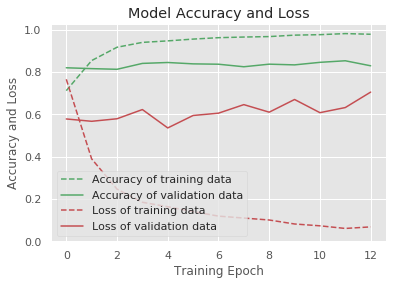

In [20]:
# %%

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

#%%

In [21]:
print("\n--- Check against test data ---\n")

# Normalize features for training data set
df_test['x-axis'] = feature_normalize(df_test['x-axis'])
df_test['y-axis'] = feature_normalize(df_test['y-axis'])
df_test['z-axis'] = feature_normalize(df_test['z-axis'])

df_test = df_test.round({'x-axis': 6, 'y-axis': 6, 'z-axis': 6})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

# Set input_shape / reshape for Keras
x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype("float32")
y_test = y_test.astype("float32")

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])


--- Check against test data ---



/home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/nsc/anaconda3/envs/py36_tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

6584/6584 [==============================] - 1s 119us/step

Accuracy on test data: 0.90

Loss on test data: 0.44



--- Confusion matrix for test data ---



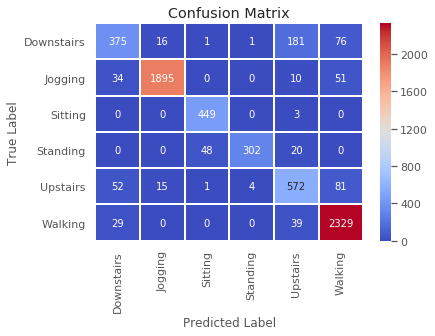


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.77      0.58      0.66       650
           1       0.98      0.95      0.97      1990
           2       0.90      0.99      0.94       452
           3       0.98      0.82      0.89       370
           4       0.69      0.79      0.74       725
           5       0.92      0.97      0.94      2397

    accuracy                           0.90      6584
   macro avg       0.87      0.85      0.86      6584
weighted avg       0.90      0.90      0.90      6584



In [22]:
# %%

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

# %%

print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))